<a href="https://colab.research.google.com/github/siddhantchawla/StyleTransfer/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [2]:
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
def load_image(img_path,shape = None):
  max_size = 400
  if "http" in img_path:
    response = requests.get(img_path)
    image = Image.open(BytesIO(response.content))
  else:
    image = Image.open(img_path).covert('RGB')

  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape is not None:
    size = shape

  im_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  
  image = im_transform(image)[:3,:,:].unsqueeze(0)

  return image 

In [0]:
content_image_path = "https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg"
style_image_path = "https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg"

In [0]:
content_image = load_image(content_image_path).to(device)
style_image = load_image(style_image_path,shape=content_image.shape[-2:]).to(device)

In [0]:
def img_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image

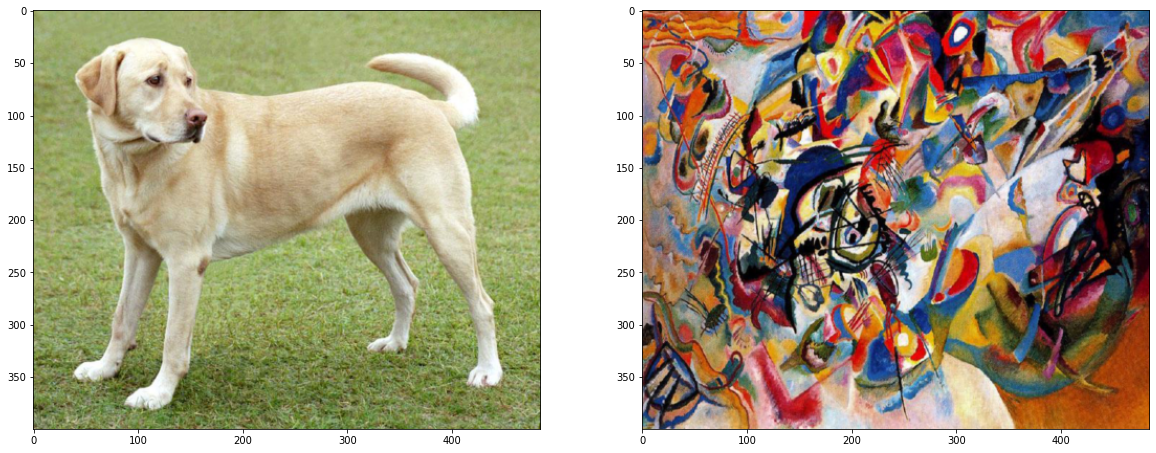

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(img_convert(content_image))
ax2.imshow(img_convert(style_image))

In [9]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
def get_features(image, model, layers = None):
  if layers is None:
    layers = {
        '0' : 'conv1_1',
        '1' : 'conv2_1',
        '2' : 'conv3_1',
        '3' : 'conv4_1',
        '4' : 'conv4_2',
        '5' : 'conv5_1'
    }
  features = {}
  x = image

  for name,layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x

  return features

In [0]:
def gram_matrix(tensor):
  b,d,h,w = tensor.size()
  tensor = tensor.view(d,h*w)
  gram = torch.mm(tensor,tensor.t())
  return gram

In [0]:
content_features = get_features(content_image,vgg)
style_features = get_features(style_image,vgg)


style_grams = {}

for layer in style_features:
  style_grams[layer] = gram_matrix(style_features[layer])

target_image = content_image.clone().requires_grad_(True).to(device)

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  3041519.5


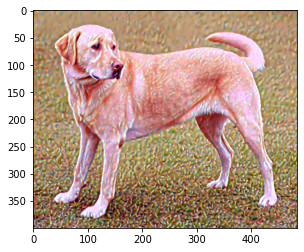

Total loss:  6899.435546875


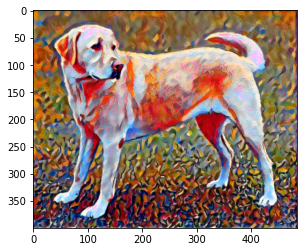

Total loss:  4581.78759765625


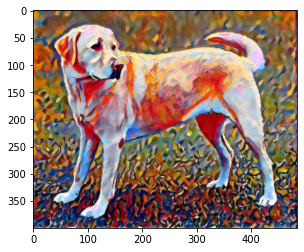

In [19]:
show_every = 400

steps = 1200
optimizer = optim.Adam([target_image],lr = 0.01)


for i in range(steps):

  target_features = get_features(target_image,vgg)
  content_loss = torch.mean(torch.pow((target_features['conv4_2'] - content_features['conv4_2']),2))

  style_loss = 0

  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    _,d,h,w = target_feature.size()

    style_gram = style_grams[layer]
    layer_style_loss = (style_weights[layer])*torch.mean(torch.pow((target_gram - style_gram),2))

    style_loss += layer_style_loss/(d*h*w)

  total_loss = content_weight*content_loss + style_weight*style_loss

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  # if  i % show_every == 0:
  #       print('Total loss: ', total_loss.item())
  #       plt.imshow(img_convert(target_image))
  #       plt.show()


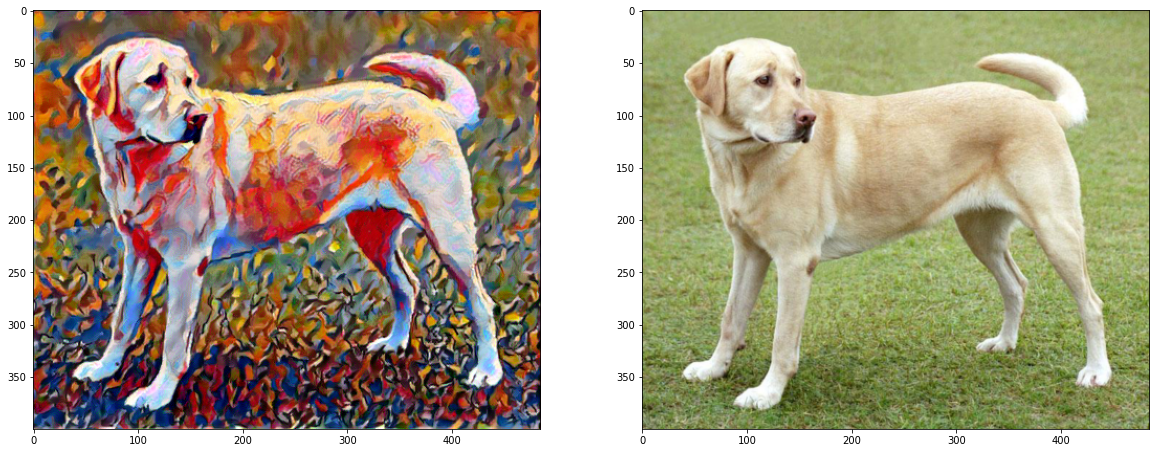

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(img_convert(target_image))
ax2.imshow(img_convert(content_image))